In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import IPython
from IPython import display
import pylab as pl
from scipy.io import wavfile
import pywt
from brian2 import *
from brian2hears import *

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 
from bss_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Sound Separation'

In [2]:
sound_paths = '../../data/Sounds'
sounds = []

rate, a = wavfile.read(os.path.join(sound_paths, 'MA02_04.wav'))
rate, b = wavfile.read(os.path.join(sound_paths, 'MH43_06.wav'))
rate, c = wavfile.read(os.path.join(sound_paths, 'MH43_09.wav'))
rate, d = wavfile.read(os.path.join(sound_paths, 'FA01_03.wav'))
rate, e = wavfile.read(os.path.join(sound_paths, 'FJ55_04.wav'))
rate, f = wavfile.read(os.path.join(sound_paths, 'MD19_07.wav'))
rate, g = wavfile.read(os.path.join(sound_paths, 'MH43_08.wav'))

a = a.astype('float64')
b = b.astype('float64')
c = c.astype('float64')
d = d.astype('float64')
e = e.astype('float64')
f = f.astype('float64')
g = g.astype('float64')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)
f_max = np.max(f)
g_max = np.max(g)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max
f /= f_max
g /= g_max

shortest = min(len(a), len(b), len(c),  len(d),  len(e), len(f), len(g))
a = a[:shortest]#[:,0]
b = b[:shortest]#[:,0]
c = c[:shortest]#[:,0]
d = d[:shortest]
e = e[:shortest]
f = f[:shortest]
g = g[:shortest]

all_sound_data = np.stack((a, b, c, d, e, f, g))

print(all_sound_data.shape)
display_matrix(np.corrcoef(all_sound_data))

(7, 32851)


<IPython.core.display.Math object>

In [3]:
def compute_vectorized_gammatone_of_rows(S, samplerate, n_center_frequencies, time_constant_of_filters = 1.019,
                                         min_freq = 20, max_freq = 20000, power_normalization_in_freq_domain = False):
    n_sources = S.shape[0]
    n_samples = S.shape[1]
    b1 =time_constant_of_filters
    center_frequencies = erbspace(min_freq*Hz, max_freq*Hz, n_center_frequencies)
    
    GammaToneMatrix = np.zeros((n_sources, n_samples * n_center_frequencies))
    
    for jj in range(n_sources):
        gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
        gt_mon = gammatone.process().T
        GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    
    gamma_tone_max = np.abs(GammaToneMatrix).max(axis = 1).reshape(-1,1)
    S = S / gamma_tone_max
    if power_normalization_in_freq_domain:
        for jj in range(n_sources):
            gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
            gt_mon = gammatone.process().T
            GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    return GammaToneMatrix, gamma_tone_max

In [4]:
np.random.seed(478)

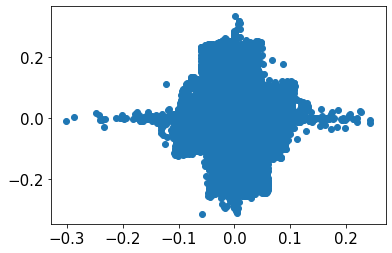

In [5]:
S = all_sound_data[np.random.choice(all_sound_data.shape[0], size=3, replace=False, p=None),:]
nbr_center_frequencies = 10
b1 = 1.019  #factor determining the time constant of the filters

S_gammaTone, S_gammaToneMax = compute_vectorized_gammatone_of_rows(S, samplerate = 16000, 
                                                                   n_center_frequencies = nbr_center_frequencies,
                                                                   time_constant_of_filters = b1, 
                                                                   min_freq = 20, max_freq = 20000, 
                                                                   power_normalization_in_freq_domain = False)
S = S / S_gammaToneMax

plt.scatter(S_gammaTone[0,:], S_gammaTone[1,:])

In [6]:
# np.random.seed(250)
NumberofMixtures = 5
NumberofSources = S.shape[0]

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

Xnoisy, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 40.00499342057297
Row standard deviation of mixtures : [0.33994473 0.67997934 0.57437597 0.59810431 0.96030296]


In [7]:
X_gammaTone, _ = compute_vectorized_gammatone_of_rows( X, samplerate = 16000, 
                                                       n_center_frequencies = nbr_center_frequencies,
                                                       time_constant_of_filters = b1, 
                                                       min_freq = 20, max_freq = 20000, 
                                                       power_normalization_in_freq_domain = False)

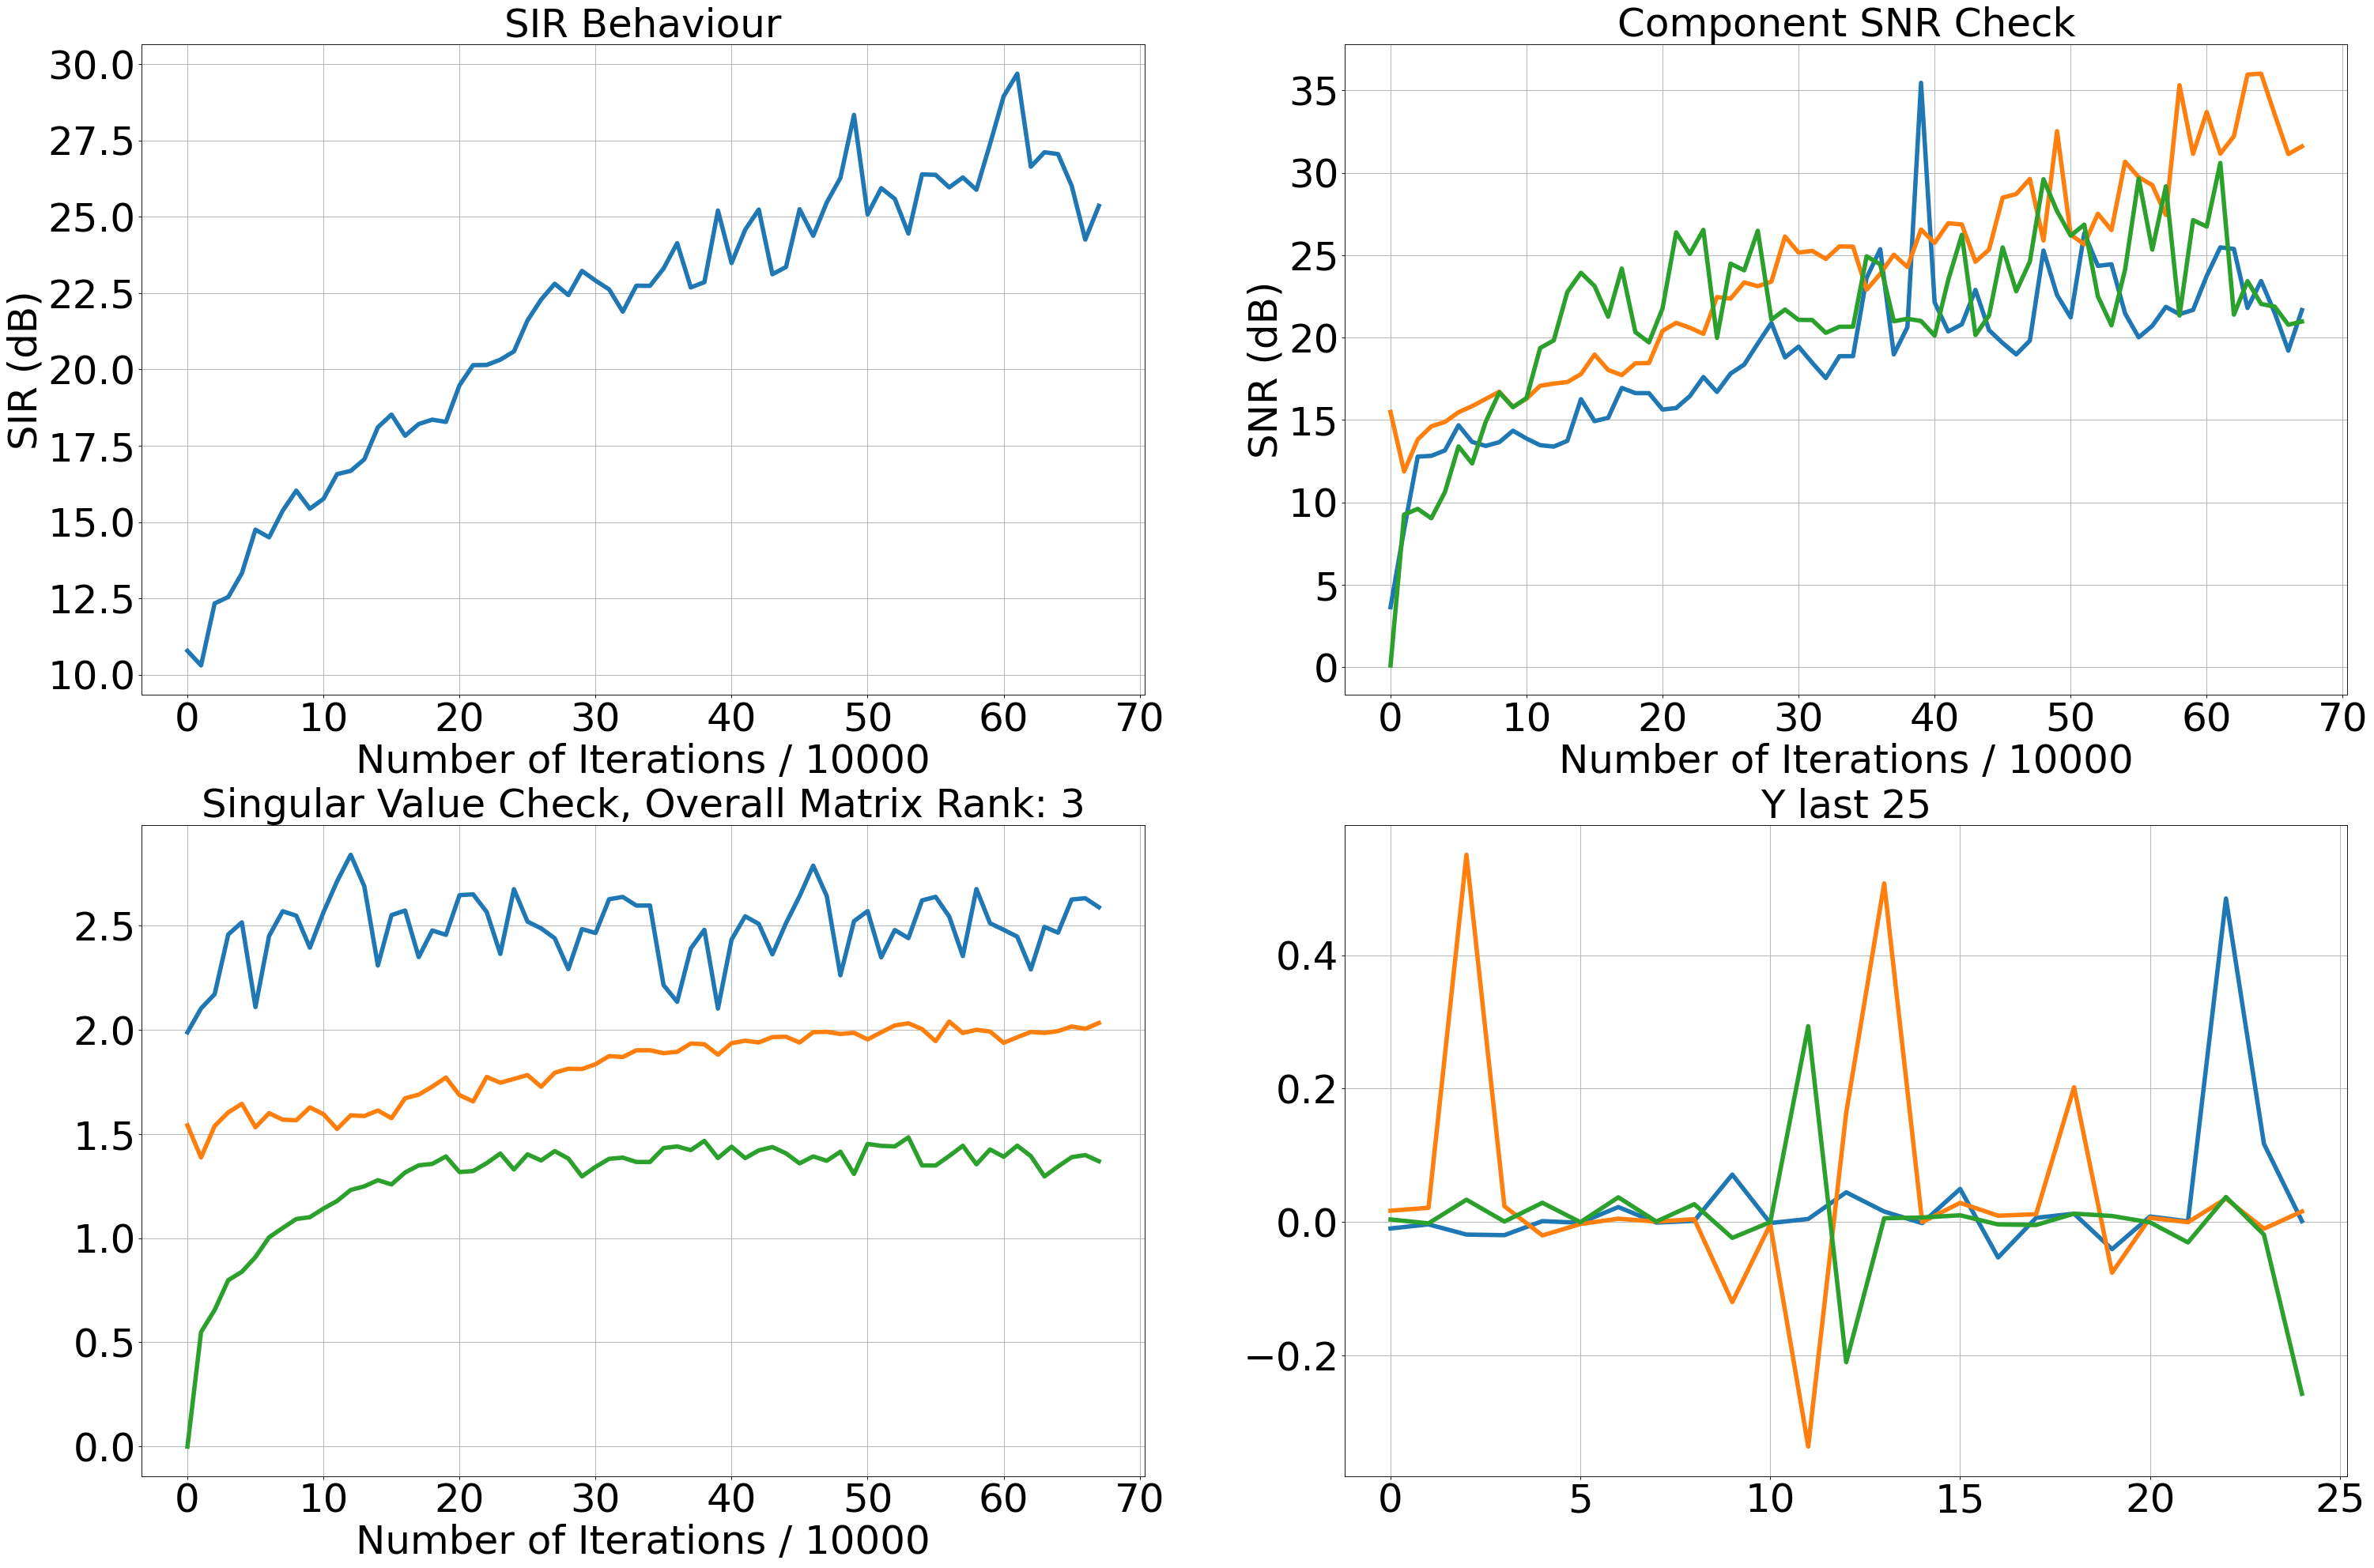

100%|██████████| 328510/328510 [05:24<00:00, 1011.75it/s]


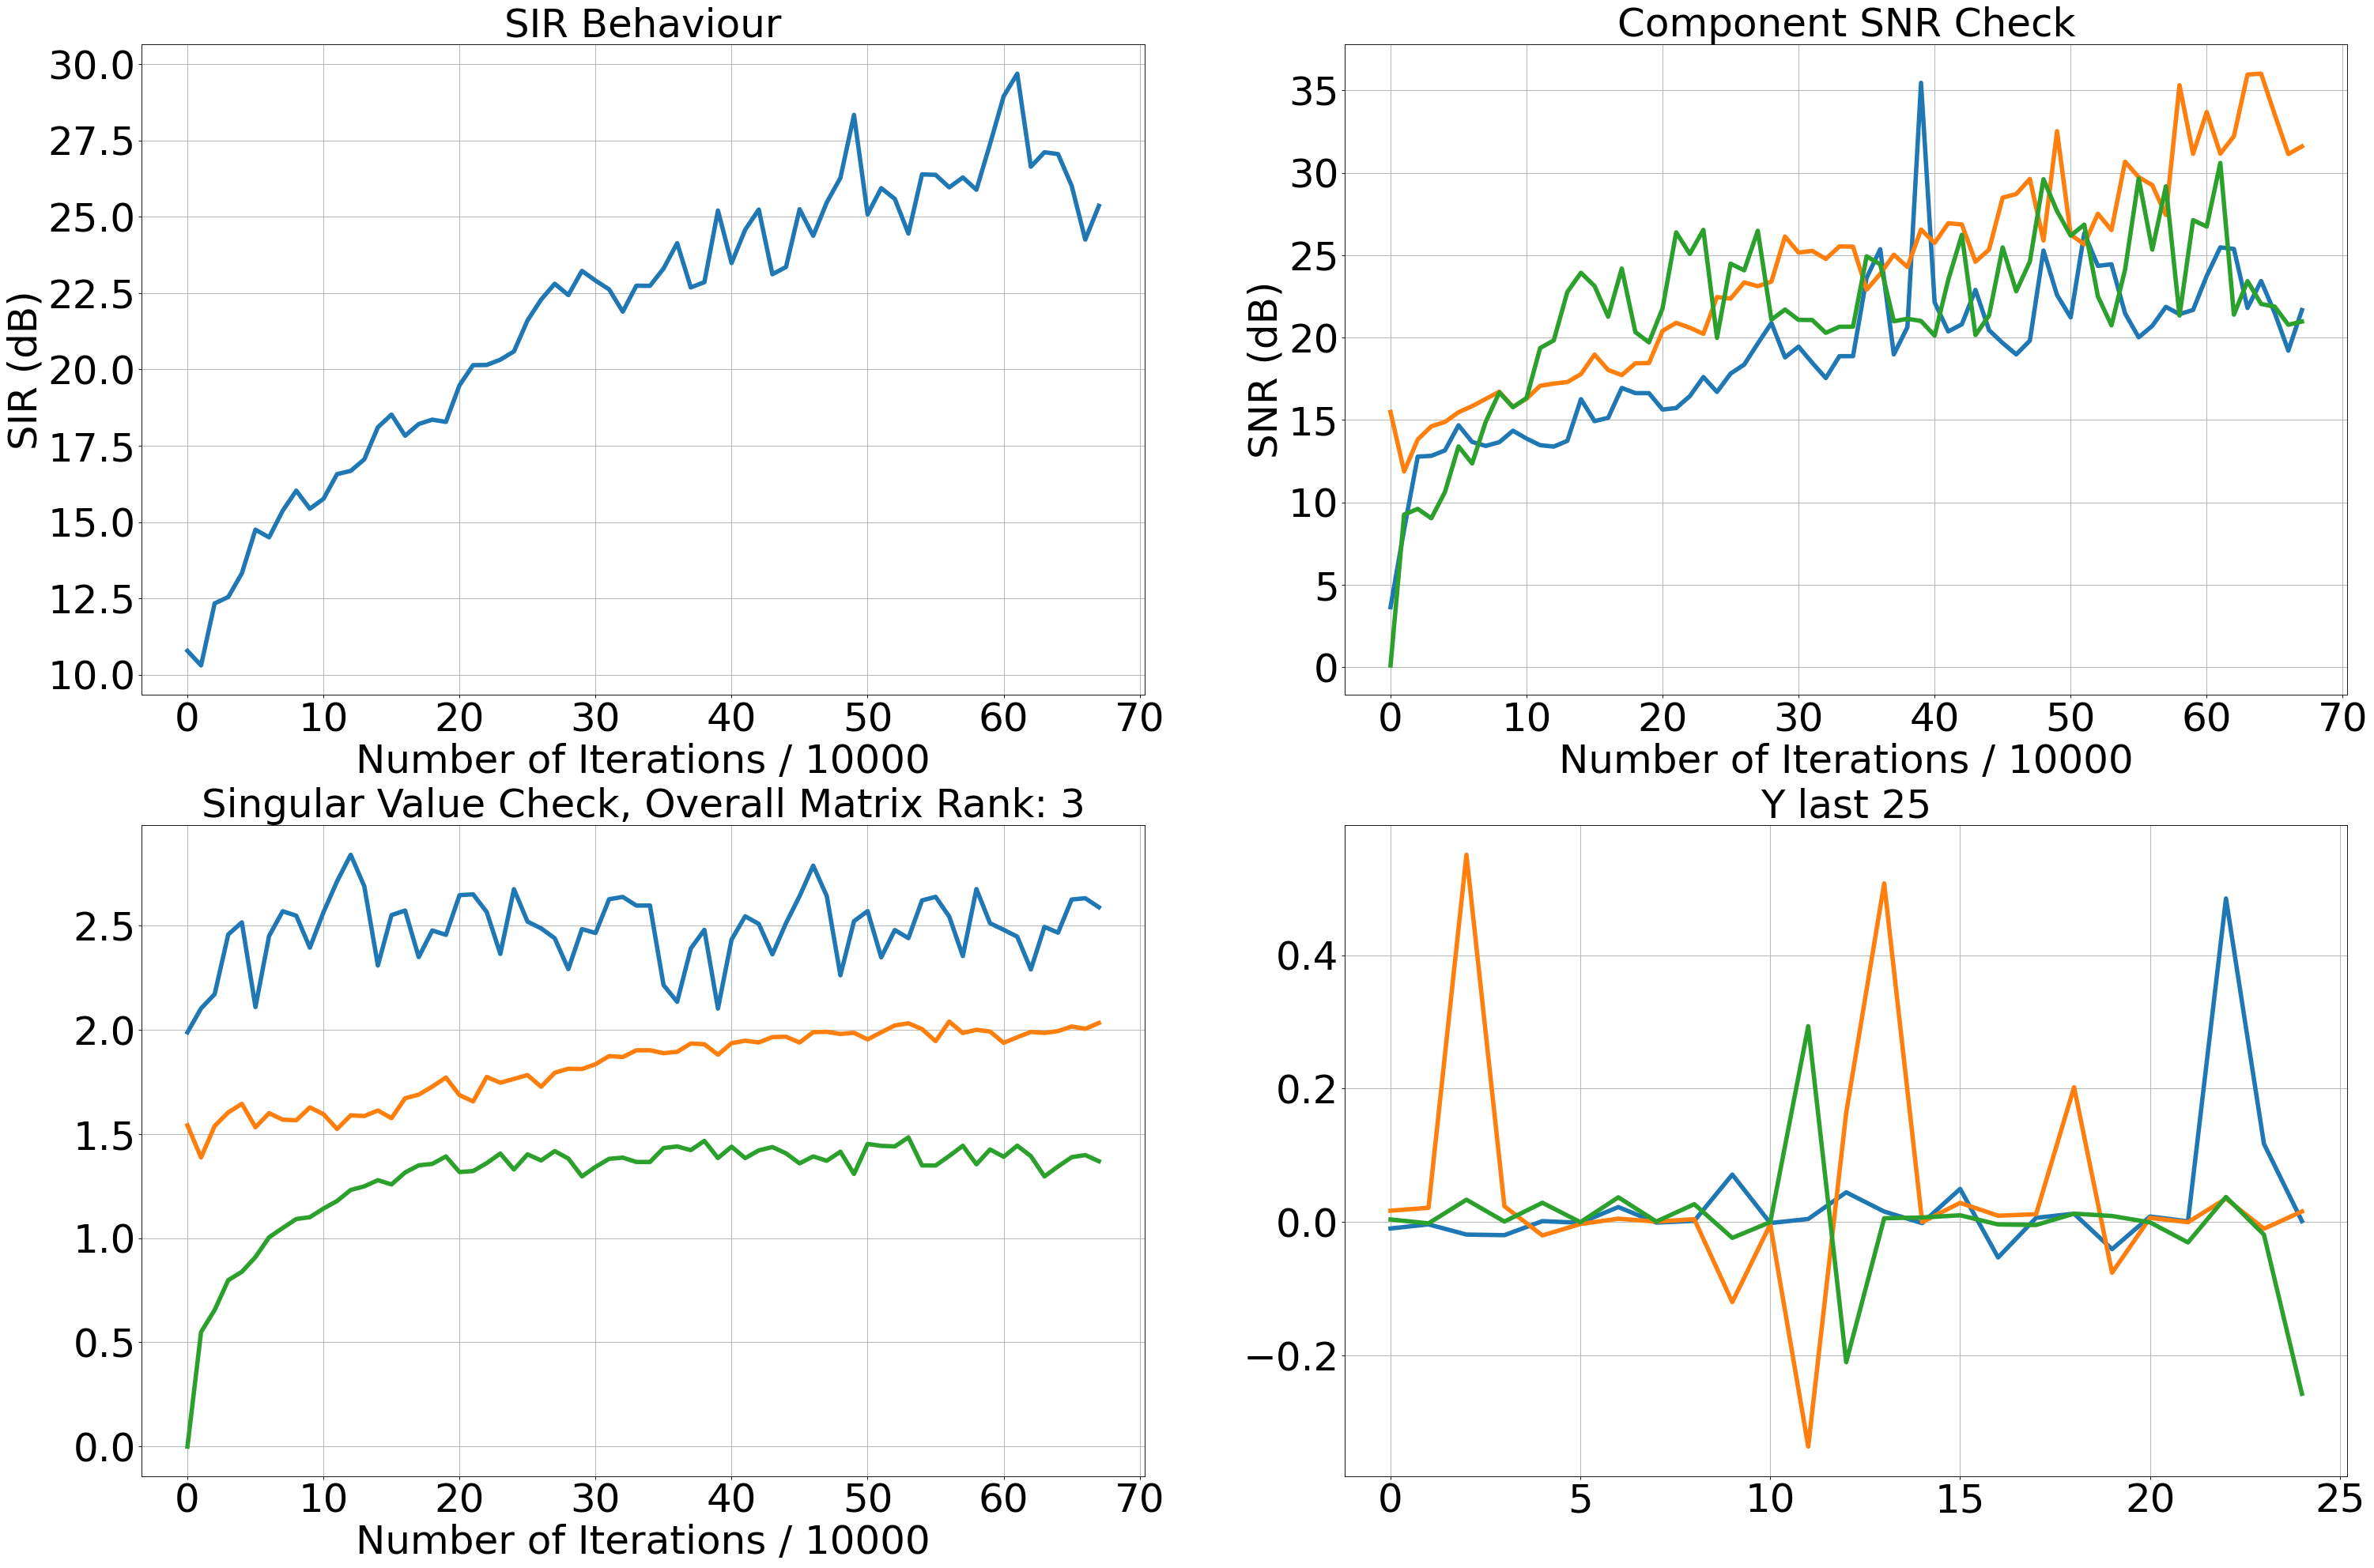

In [8]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 10000

lambday = 1 - 1e-1/50
lambdae = 1 - 1e-1/50
# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 2000 * np.eye(s_dim)

modelCorInfoMax = OnlineCorInfoMax( s_dim = s_dim, x_dim = x_dim, muW = 50*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = S_gammaTone, A = A)
with Timer() as t:
    modelCorInfoMax.fit_batch_sparse(       X = X_gammaTone, n_epochs = 2, 
                                            neural_dynamic_iterations = 500,
                                            plot_in_jupyter = True,
                                            neural_lr_start = 0.25,
                                            neural_lr_stop = 0.01, 
                                            debug_iteration_point = debug_iteration_point, 
                                            shuffle = True)

In [9]:
Wf = modelCorInfoMax.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [21.5799984  30.87182105 21.44139094]

Overall SINR : 24.748652702755063
